# Learning Objectives

Towards the end of this lesson, you should be able to:
- understand and programming in Logistic regression, k-NN, Naive Bayes
- determine k value for optimal k-NN 
- perform prediction on new data


# Load Python Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11,6)})
plt.rc("font", size=14)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from scipy.stats import spearmanr 

import missingno as msno

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

# !pip install missingno

# Logistic Regression

### Read Dataset

In [2]:
# load dataset

df = pd.read_csv('banking.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
df.shape

(41188, 21)

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

### Data Exploratory

<AxesSubplot:xlabel='age', ylabel='duration'>

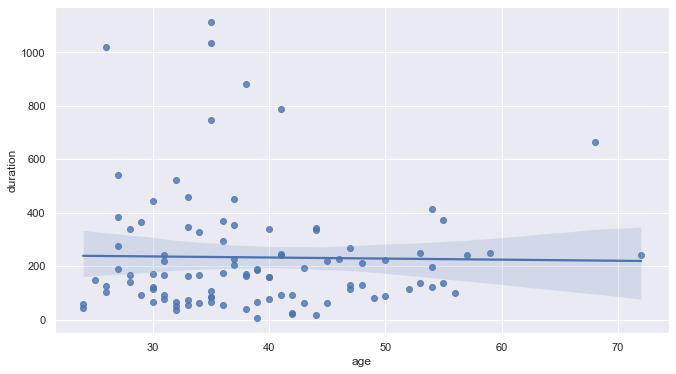

In [6]:
# plot scatterplot for age vs. duration

df_tmp = df.loc[1:100,['age','duration']]
sns.regplot(x='age',y='duration',data=df_tmp)

In [7]:
# check the correlation between age and duration
# if the p_value is bigger than 0.05, it is not significant statistically

age = df.loc[1:100,['age']]
duration = df.loc[1:100,['duration']]
spearmanr_coef, p_value = spearmanr(age,duration)

print("coefficient = ", spearmanr_coef)
print("p_value = ", p_value)

coefficient =  0.03627018469989538
p_value =  0.720148971329184


### Check missing values

<AxesSubplot:>

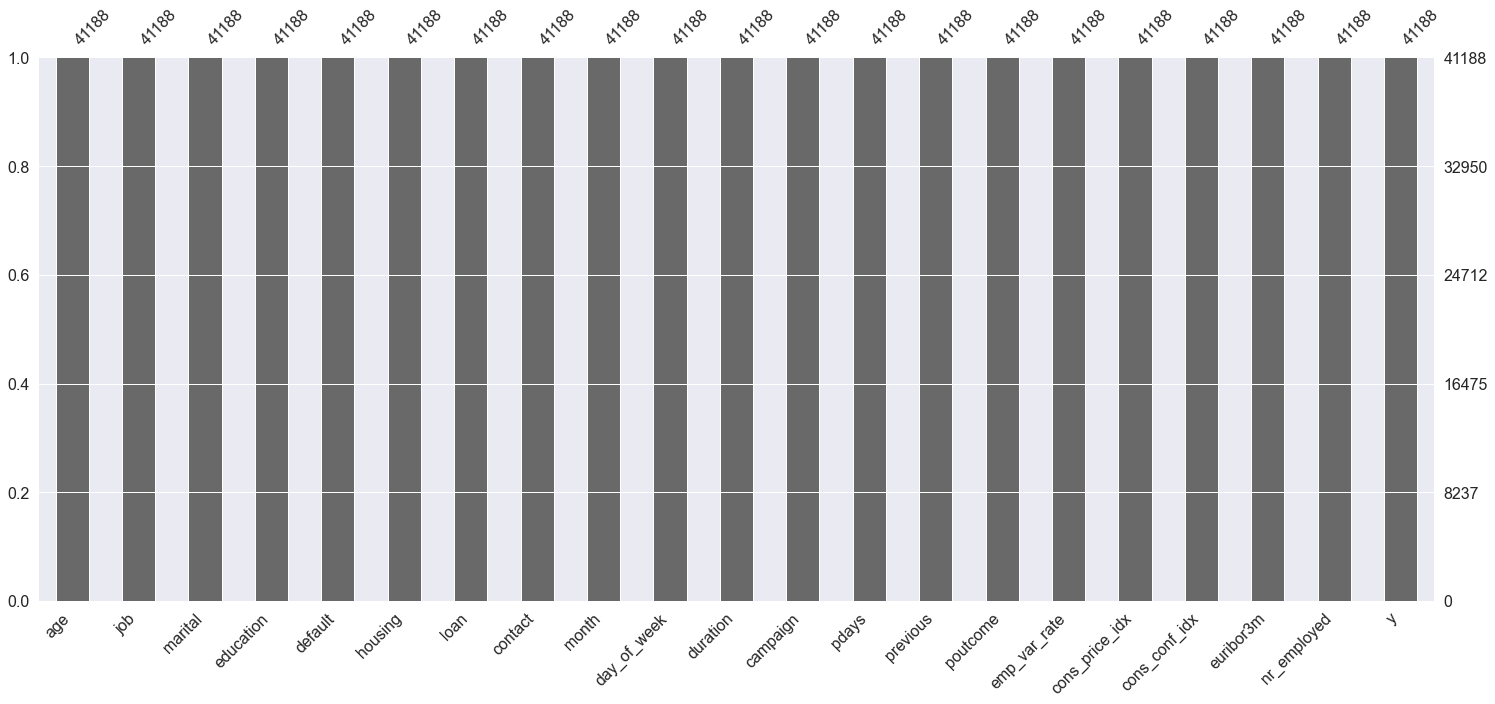

In [8]:
df.isnull().sum()
msno.bar(df)

In [9]:
df = df.dropna()
df = df.fillna(0)

### Check the class label distribution 'y'


In [10]:
df.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

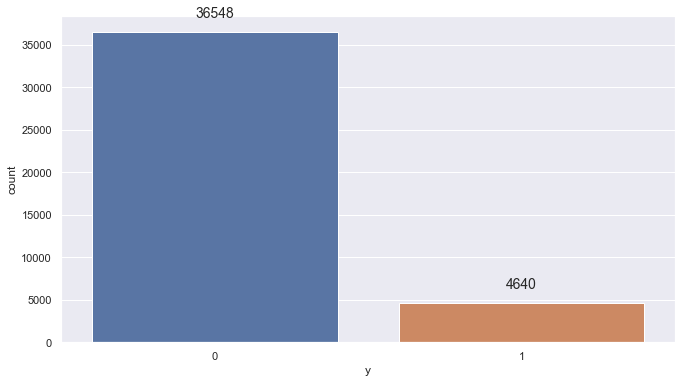

In [11]:
b=sns.countplot(x='y', data = df)

for p in b.patches:
    	b.annotate("%.0f" % p.get_height(), (p.get_x() + 
	p.get_width() / 2., p.get_height()), 
    	ha='center', va='center', rotation=0, 
	xytext=(0, 18), textcoords='offset points')

### Basic Transformation

In [12]:
# before transformation

df['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [13]:
# replace basic.9y, basic.6y, basic.4y to "Basic"

df['education']=np.where(df['education'] =='basic.9y', 'Basic', df['education'])
df['education']=np.where(df['education'] =='basic.6y', 'Basic', df['education'])
df['education']=np.where(df['education'] =='basic.4y', 'Basic', df['education'])

In [14]:
# after transformation

df['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [15]:
# get the distribution of y

count_no_sub = len(df[df['y']==0])
count_sub = len(df[df['y']==1])

pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)

pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


In [16]:
# get the mean for each attribute grouped by y
df.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


### Visualizing attributes with respect to y

Text(0, 0.5, 'Frequency of Purchase')

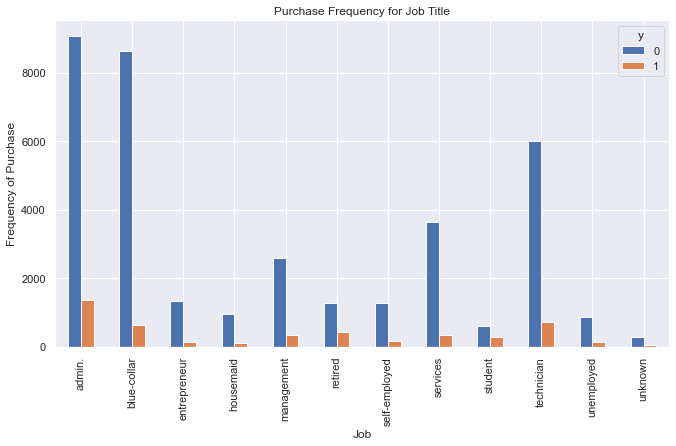

In [17]:
a=pd.crosstab(df.job,df.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase') 


In [19]:
pd.crosstab(df.job,df.y)

y,0,1
job,,
admin.,9070,1352
blue-collar,8616,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1286,434
self-employed,1272,149
services,3646,323
student,600,275


Text(0, 0.5, 'Proportion of Customers')

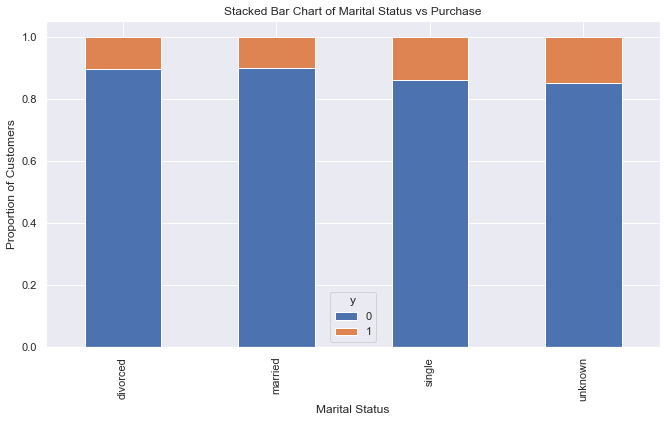

In [23]:
# build a crosstab for marital agains y and plot the barchart

table = pd.crosstab(df.marital,df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
plt.title("Stacked Bar Chart of Marital Status vs Purchase")
plt.xlabel("Marital Status")
plt.ylabel("Proportion of Customers")


Text(0, 0.5, 'Proportion of Customers')

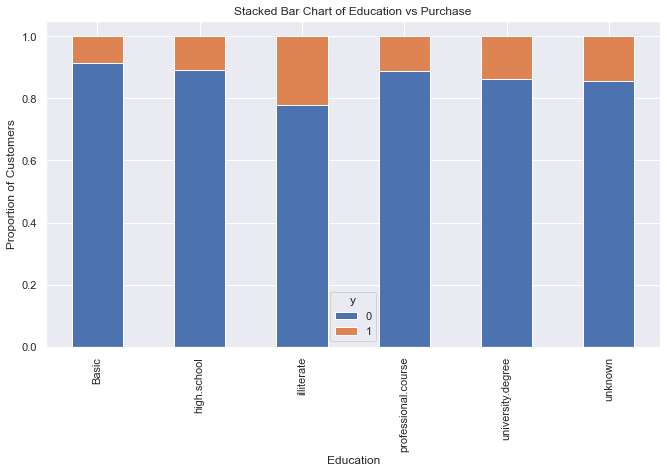

In [24]:
# build a crosstab for education agains y and plot the barchart

table = pd.crosstab(df.education,df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
plt.title("Stacked Bar Chart of Education vs Purchase")
plt.xlabel("Education")
plt.ylabel("Proportion of Customers")


Text(0, 0.5, 'Frequency')

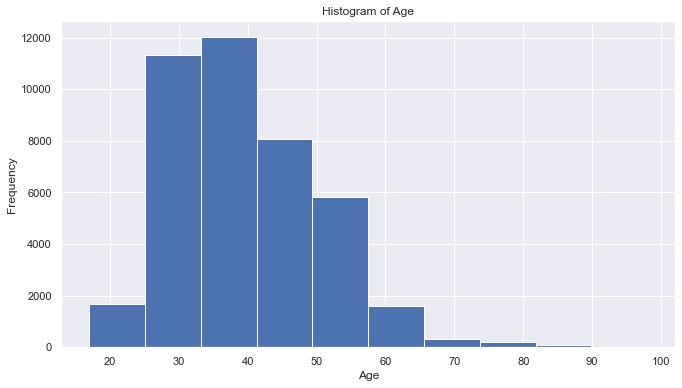

In [25]:
# plot the histogram of age

df.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency') 

### Dummifying the Variables (one-hot encoding)

In [26]:
# Dummifying only the variables with object data type
# the dataset of we have must be numericals to represent yes or no

cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

df_vars=df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in cat_vars]

In [27]:
df_final=df[to_keep]
df_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype=object)

In [28]:
df_final

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...
41183,59,222,1,999,0,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,196,2,999,0,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,62,3,999,0,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,200,2,999,0,-3.4,92.431,-26.9,0.742,5017.5,0


### Over-sampling using SMOTE

In [29]:
# Determine the X and y...

X = df_final.loc[:, df_final.columns != 'y']
y = df_final.loc[:, df_final.columns == 'y']

# construct the SMOTE model
os = SMOTE(random_state=42)

# train-test-split with test size 30% and random state=10
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=10)
columns = X_train.columns

# fit the smote model with training data only
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

# change to dataframe

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51232
Number of no subscription in oversampled data 25616
Number of subscription 25616
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### Using statsmodels for Logistic Regression

In [33]:
import statsmodels.api as sm

# create the logistic regression model using statsmodels. The max iteration = 200
logit_model = sm.Logit(y,X)
result = logit_model.fit(maxiter=200)

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.219946
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.375     
Dependent Variable: y                AIC:              18138.2946
Date:               2022-10-25 21:52 BIC:              18224.5536
No. Observations:   41188            Log-Likelihood:   -9059.1   
Df Model:           9                LL-Null:          -14499.   
Df Residuals:       41178            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age               0.0018   0.0016   1.0936 0.2741 -0.0014  0.0050
duration          0.0046   0.0001  63.5077 0.0000  0.0044  0.0047


### Using sklearn for Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Use solver='lbfgs' and max iteration = 200 for the logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size = 0.3, random_state = 0)
logreg =LogisticRegression(solver = 'lbfgs', max_iter = 100)
logreg.fit(X_train, y_train)

# getting the model accuracy
logreg.score(X_test, y_test)

0.9117908877559278

In [36]:
# Prediction

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


In [37]:
# get the predicted y values

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
# Accuracy of the model

accuracy_score(y_test, y_pred)

0.9117908877559278

# K-NN

### Load Dataset

In [39]:
# Load dataset

dataset = pd.read_csv('iris.csv')

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [41]:
dataset.head(10)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


### Train-Test-Split

In [42]:
# For this example, we use the mass, width, and height features of each fruit instance
X = dataset.drop('Species', axis=1) # input to the model to predict what species it is
y = dataset['Species'] # alll the species

In [45]:
X

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [46]:
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: Species, Length: 150, dtype: object

In [47]:
# default is 75% / 25% train-test split. Random state = 10

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 7)

In [48]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(112, 4)
(112,)
(38, 4)
(38,)


### Create the k-NN model

In [50]:
# Create the k-NN model with 5 neighbours

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

**Use the trained k-NN classifier model to classify new, previously unseen objects:**

In [52]:
# Perform prediction

species_prediction = knn.predict([[2, 3.2, 1.5, 0.5]])
print('species name is '+species_prediction[0])


species name is setosa


In [53]:
# Perform prediction

species_prediction = knn.predict([[2.5, 5, 4, 4]])
print('species name is '+species_prediction[0])

species name is virginica


**Estimate the accuracy of the classifier on future data, using the test data:**

In [54]:
#accuracy

knn.score(X_test, y_test)

0.8947368421052632

### How sensitive is k-NN classification accuracy to the choice of the 'k' parameter?

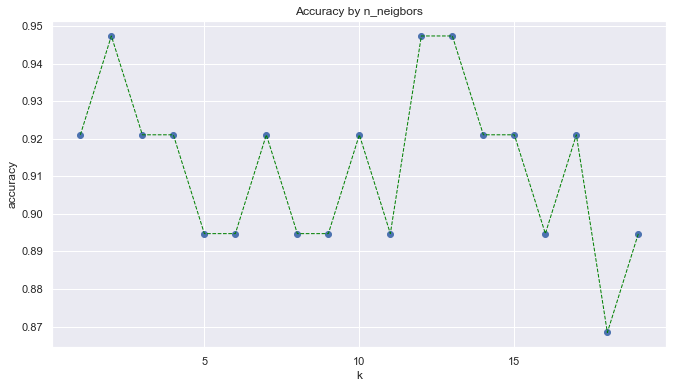

In [55]:
k_range = range(1,20)
scores = []

# Using loop to study the influence of k towards the score. Use append() to append the scores into the list
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))


plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Accuracy by n_neigbors')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);
plt.plot(k_range, scores, color='green', linestyle='dashed', linewidth=1, markersize=5)

# Naive Bayes

In [56]:
df=pd.read_csv('iris.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [57]:
df.shape

(150, 5)

### Train-Test-Split dataset

In [58]:
# For this example, we use the mass, width, and height features of each fruit instance
X = df.drop('Species', axis=1)
y = df['Species']

In [61]:
# train-test-split with 30% test size and random state=10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [62]:
# Construct the NB model

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [63]:
# Perform prediction on X_test

y_pred = nb.predict(X_test)
y_pred

array(['versicolor', 'virginica', 'setosa', 'versicolor', 'setosa',
       'versicolor', 'versicolor', 'versicolor', 'setosa', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'setosa', 'setosa',
       'virginica', 'versicolor', 'setosa', 'setosa', 'setosa',
       'virginica', 'virginica', 'virginica', 'setosa', 'versicolor',
       'setosa', 'versicolor', 'versicolor', 'versicolor', 'virginica',
       'versicolor', 'versicolor', 'virginica', 'virginica', 'virginica',
       'setosa', 'virginica', 'virginica', 'virginica', 'virginica',
       'setosa', 'setosa', 'versicolor', 'setosa', 'versicolor'],
      dtype='<U10')

In [64]:
# get the predicted output for [2, 3.2, 1.5, 0.5]

species_prediction = nb.predict([[2, 3.2, 1.5, 0.5]])
print('species name is '+species_prediction[0])

species name is setosa


In [65]:
# get the predicted output for [2.5, 5, 4, 4]

species_prediction = nb.predict([[2.5, 5, 4, 4]])
print('species name is '+species_prediction[0])

species name is virginica


In [66]:
# accuracy of the constructed NB model

nb.score(X_test, y_test)

1.0